# Table of contents

- [1. Loading libraries and data](#1-loading-libraries-and-data)
  - [1.1 Loading libraries](#11-loading-libraries)
  - [1.2 Loading data](#12-loading-data)
- [2. Processing data](#2-processing-data) 
  - [2.1 Listings](#21-listings)
  - [2.2 Calendar](#22-calendar)
- [3. Data exploration](#3-data-exploration)
  - [3.1 Neighbourhoods](#31-neighbourhoods)
  - [3.2 Room types](#32-room-types)
  - [3.3 Accommodates](#33-accommodates)
  - [3.4 Reviews](#34-reviews)
- [4. Analysis](#4-analysis)
  - [4.1 Price vs Location](#41-price-vs-location-analysis)
  - [4.2 Availability](#42-availability)
  - [4.3 Quality of hosts](#43-quality-of-hosts)

Since Argentina is a country affected by high inflation rates, **it should be noted that this dataset corresponds to April 2024**.

# 1. Loading libraries and data

## 1.1 Loading libraries

In [203]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# To make interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

## 1.2 Loading data

In [204]:
import os
print(os.listdir("input"))

['calendar.csv', 'listings.csv', 'listings_details.csv', 'neighbourhoods.csv', 'neighbourhoods.geojson']


In [205]:
listings_df = pd.read_csv("input/listings.csv", index_col="id", low_memory=False)
listings_details_df = pd.read_csv("input/listings_details.csv", index_col="id", low_memory=False)

calendar_df = pd.read_csv("input/calendar.csv", index_col="listing_id")

# 2. Processing data

### 2.1 Listings

First, we will take a look at the raw data.

We will start with the listings dataframes as we are looking to merge both into one.

In [206]:
print(listings_df.shape)
listings_df.head()

(36561, 17)


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
id,,,,,,,,,,,,,,,,,
111501,Sunny Apartment Palermo Boulevard Cerviño,570921,Emilce,NaN,Palermo,-34.57901,-58.41283,Entire home/apt,41089.0,4,155,2024-04-03,1.00,2,314,12,NaN
111934,Bright Studio at Palermo Soho,570921,Emilce,NaN,Palermo,-34.58199,-58.42776,Entire home/apt,34847.0,4,131,2024-02-26,0.83,2,355,22,NaN
117548,"Palermo, Buenos Aires: Complete flat: ""Alma Mia"".",454822,D. / Lola,NaN,Palermo,-34.57271,-58.41893,Entire home/apt,39340.0,5,5,2024-02-25,0.53,2,210,5,NaN
118069,Great 1 Bedroom - 1.5 Bath,530261,Luciano,NaN,Palermo,-34.57978,-58.43223,Entire home/apt,37338.0,14,21,2022-05-31,0.14,29,334,0,NaN
11508,Amazing Luxurious Apt-Palermo Soho,42762,Candela,NaN,Palermo,-34.58184,-58.42415,Entire home/apt,59325.0,3,40,2024-03-05,0.28,1,336,5,NaN


In [207]:
listings_df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [208]:
print(listings_details_df.shape)
listings_details_df.columns

(36561, 74)


Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

We will select the variables that are relevant to our analysis

In [209]:
target_columns = ["host_location", "host_is_superhost", "host_response_time", "host_since", "accommodates", "bathrooms", "bedrooms", "beds", 
                  "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", 
                  "review_scores_communication", "review_scores_checkin", "review_scores_rating"]
listings_df = pd.merge(listings_df, listings_details_df[target_columns], on="id", how="left")
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36561 entries, 111501 to 1144127852568754731
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            36561 non-null  object 
 1   host_id                         36561 non-null  int64  
 2   host_name                       36561 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   36561 non-null  object 
 5   latitude                        36561 non-null  float64
 6   longitude                       36561 non-null  float64
 7   room_type                       36561 non-null  object 
 8   price                           33911 non-null  float64
 9   minimum_nights                  36561 non-null  int64  
 10  number_of_reviews               36561 non-null  int64  
 11  last_review                     29679 non-null  object 
 12  reviews_per_month 

We will drop neighbourhood_group because all its values are null, and other columns that we won't use. Also, we will reorder columns for readability.

In [210]:
listings_df = listings_df[["price", "neighbourhood", "latitude", "longitude", "room_type", "accommodates", 
                          "bathrooms", "bedrooms", "beds", "availability_365", "number_of_reviews", "review_scores_value", 
                          "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", 
                          "review_scores_communication", "review_scores_checkin", "review_scores_rating", 
                          "host_id", "host_is_superhost", "host_location", "host_response_time", "host_since"]]
listings_df.head()

,price,neighbourhood,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,availability_365,...,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,host_id,host_is_superhost,host_location,host_response_time,host_since
id,,,,,,,,,,,,,,,,,,,,,
111501,41089.0,Palermo,-34.57901,-58.41283,Entire home/apt,4,1.0,0.0,2.0,314,...,4.96,4.89,4.97,4.92,4.79,570921,t,"Buenos Aires, Argentina",within an hour,2011-05-09
111934,34847.0,Palermo,-34.58199,-58.42776,Entire home/apt,2,1.0,0.0,1.0,355,...,4.83,4.80,4.90,4.85,4.78,570921,t,"Buenos Aires, Argentina",within an hour,2011-05-09
117548,39340.0,Palermo,-34.57271,-58.41893,Entire home/apt,2,1.5,2.0,2.0,210,...,4.80,4.60,5.00,4.80,4.80,454822,f,"Buenos Aires, Argentina",within a few hours,2011-03-21
118069,37338.0,Palermo,-34.57978,-58.43223,Entire home/apt,3,1.5,1.0,1.0,334,...,4.81,4.57,4.71,4.90,4.55,530261,t,"Buenos Aires, Argentina",within an hour,2011-04-23
11508,59325.0,Palermo,-34.58184,-58.42415,Entire home/apt,2,1.0,1.0,1.0,336,...,4.92,4.92,4.97,4.92,4.80,42762,t,"New York, NY",within a day,2009-10-01


We will also replace "t" and "f" in boolean variables to True and False

In [211]:
listings_df["host_is_superhost"] = listings_df["host_is_superhost"].replace({"t": True, "f": False})

Let's now check if there is any outliers in the price data.

In [212]:
listings_df["price"].describe()

count    3.391100e+04
mean     5.954551e+04
std      7.015697e+05
min      2.600000e+02
25%      2.273000e+04
50%      3.059800e+04
75%      4.371200e+04
max      4.371150e+07
Name: price, dtype: float64

We can see that there seems to be outliers. 

On the upper end there are huge values that could be real prices of luxury places but for our analysis we will remove them.

On the lower end there is definitely something wrong, as our minimum daily price is ARS$260 (around USD$0.26 at the time), which doesn't make sense.

In [213]:
listings_df_prev = listings_df.copy()

upper_bound = listings_df['price'].quantile(0.99)
lower_bound = listings_df['price'].quantile(0.01)

print(upper_bound, lower_bound)

240413.0 10000.0


In [214]:
listings_df = listings_df[(listings_df['price'] >= lower_bound) & (listings_df['price'] <= upper_bound)]
print ("Shape before removing outliers: ", listings_df_prev.shape)
print ("Shape after removing outliers: ", listings_df.shape)

Shape before removing outliers:  (36561, 23)
Shape after removing outliers:  (33246, 23)


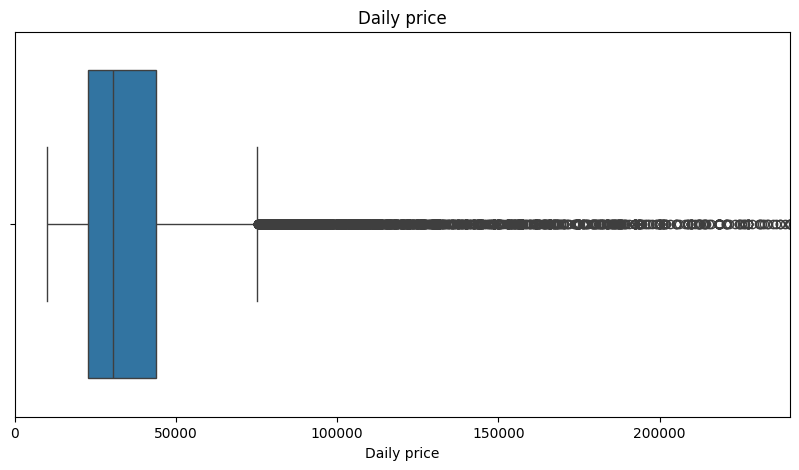

count     33246.000000
mean      38656.199422
std       27452.948558
min       10000.000000
25%       22730.000000
50%       30598.000000
75%       43712.000000
max      240413.000000
Name: price, dtype: float64


In [215]:
# Plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=listings_df["price"])

# Add title and label
plt.title("Daily price")
plt.xlabel("Daily price")

plt.xlim(0, listings_df["price"].max())

plt.show()
print(listings_df["price"].describe())

### 2.2 Calendar

Now let's take a look at the calendar dataframe

In [216]:
calendar_df.head()

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
11508,2024-04-29,f,$65.00,NaN,3.0,1125.0
11508,2024-04-30,f,$65.00,NaN,3.0,1125.0
11508,2024-05-01,f,$65.00,NaN,3.0,1125.0
11508,2024-05-02,f,$65.00,NaN,3.0,1125.0
11508,2024-05-03,f,$65.00,NaN,3.0,1125.0


In [217]:
calendar_df.shape

(13344511, 6)

In [218]:
calendar_df.isnull().sum()

date                     0
available                0
price                    0
adjusted_price    13344511
minimum_nights          12
maximum_nights          12
dtype: int64

We will drop the adjusted_price column which only has null values and transform price to float and available to False for "f" and True for "t".

In [219]:
# Drop adjusted_price column
calendar_df.drop(columns="adjusted_price", inplace=True)

# Transform price to float (e.g. "$3,211.00" to 3211.00)
calendar_df["price"] = calendar_df["price"].str.replace("$", "").str.replace(",", "").astype(float)

# Transform available "f" and "t" to 0s and 1s
calendar_df["available"] = calendar_df["available"].replace({"f": False, "t": True})

calendar_df.head()

D:\Shit\Temp\ipykernel_9148\222007211.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,date,available,price,minimum_nights,maximum_nights
listing_id,,,,,
11508,2024-04-29,False,65.0,3.0,1125.0
11508,2024-04-30,False,65.0,3.0,1125.0
11508,2024-05-01,False,65.0,3.0,1125.0
11508,2024-05-02,False,65.0,3.0,1125.0
11508,2024-05-03,False,65.0,3.0,1125.0


Price data in calendars is mostly in US Dollars, which make sense. But there is a significate portion of data which has non-sensical values. We will deal with this later, after we analyze number of listings by date.

Removing a big percent of data because prices are wrong would skew our analysis of listings quantity, because even prices being wrong doesn't mean the listing is invalid.

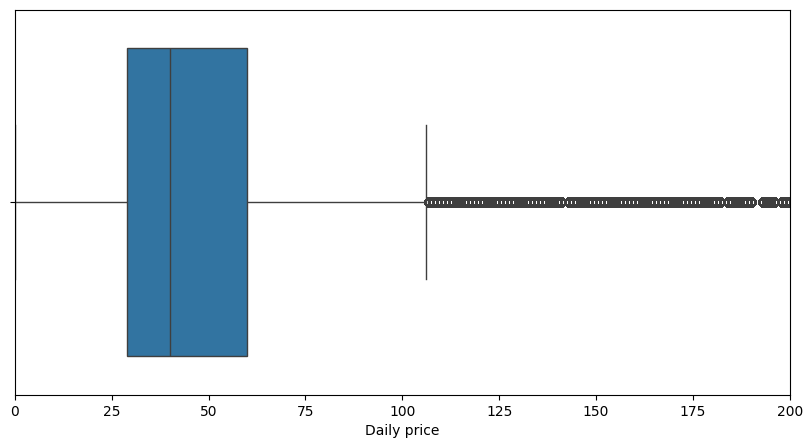

count    1.334451e+07
mean     1.304638e+03
std      3.130813e+04
min      0.000000e+00
25%      2.900000e+01
50%      4.000000e+01
75%      6.000000e+01
max      4.500000e+06
Name: price, dtype: float64


In [220]:
# Plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=calendar_df["price"])

# Add title and label
plt.xlabel("Daily price")

plt.xlim(0, 200)

plt.show()
print(calendar_df["price"].describe())

# 3. Data exploration

## 3.1 Neighbourhoods

Neighbourhood Palermo holds most listings, with 10835 listings, followed by Recoleta with 4834. These two neighbourhood hold almost half (47.13%) of the total listings in Buenos Aires.

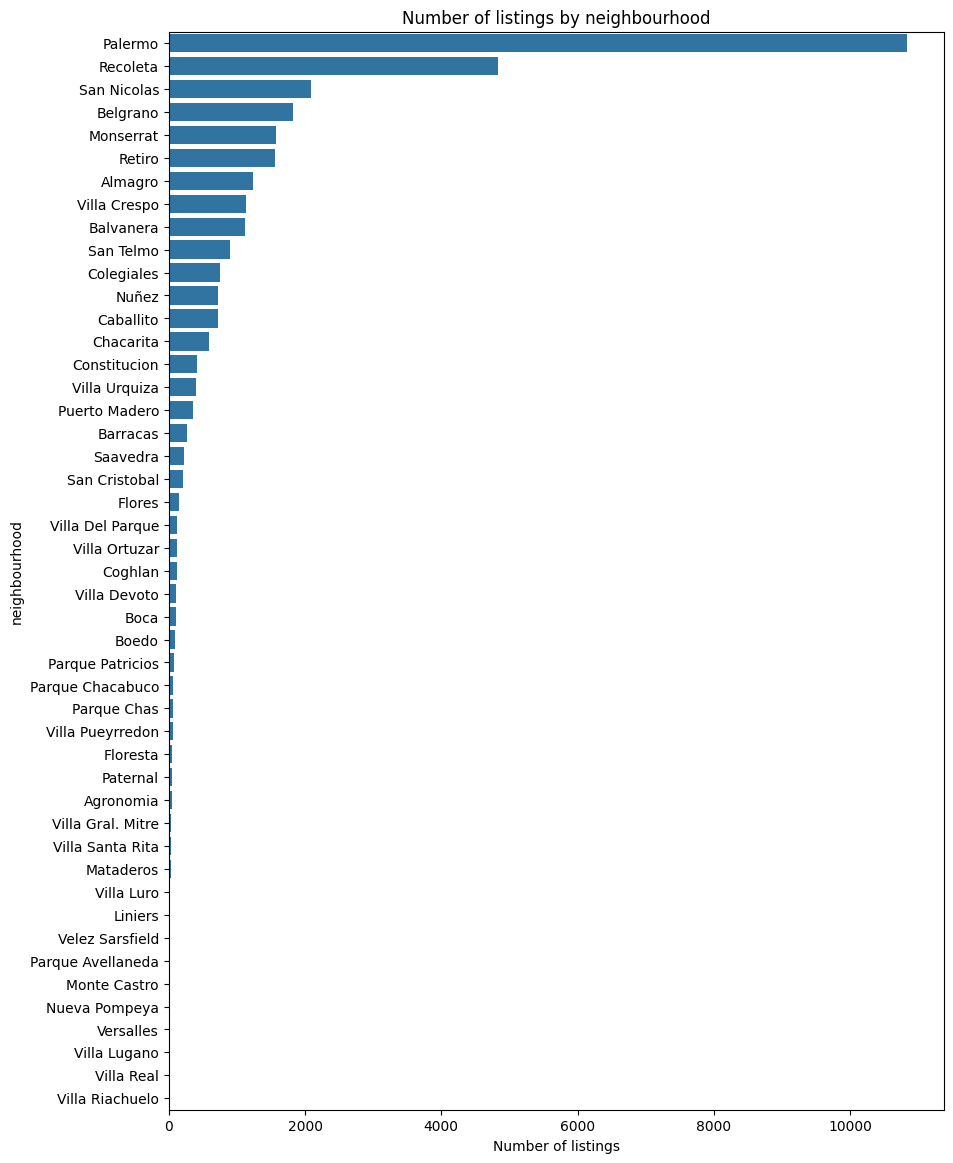

In [221]:
freq = listings_df["neighbourhood"].value_counts().sort_values(ascending=False)

# Plot horizontal barplot
plt.figure(figsize=(10, 14))
sns.barplot(x=freq.values, y=freq.index, orient="h")

# Add label and title
plt.xlabel("Number of listings")
plt.title("Number of listings by neighbourhood")

plt.show()

In [222]:
total_listings = freq.sum()

percent_palermo = (freq["Palermo"] / total_listings) * 100
percent_recoleta = (freq["Recoleta"] / total_listings) * 100

print(f"Percentage of listings in Palermo: {percent_palermo:.2f}%")
print(f"Percentage of listings in Recoleta: {percent_recoleta:.2f}%")
print(f"Total number of listings: {total_listings}")

Percentage of listings in Palermo: 32.59%
Percentage of listings in Recoleta: 14.54%
Total number of listings: 33246


## 3.2 Room types

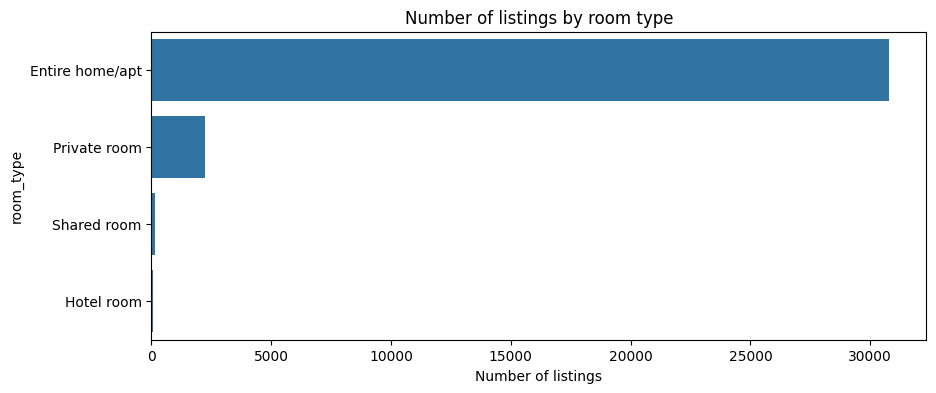

In [223]:
freq = listings_df["room_type"].value_counts().sort_values(ascending=False)

# Plot horizontal barplot
plt.figure(figsize=(10, 4))
sns.barplot(x=freq.values, y=freq.index, orient="h")

# Add label and title
plt.xlabel("Number of listings")
plt.title("Number of listings by room type")

plt.show()

## 3.3 Accommodates

As expected, most listings are for 2 people. Also, Airbnb uses a maximum of 16 guests per listing.

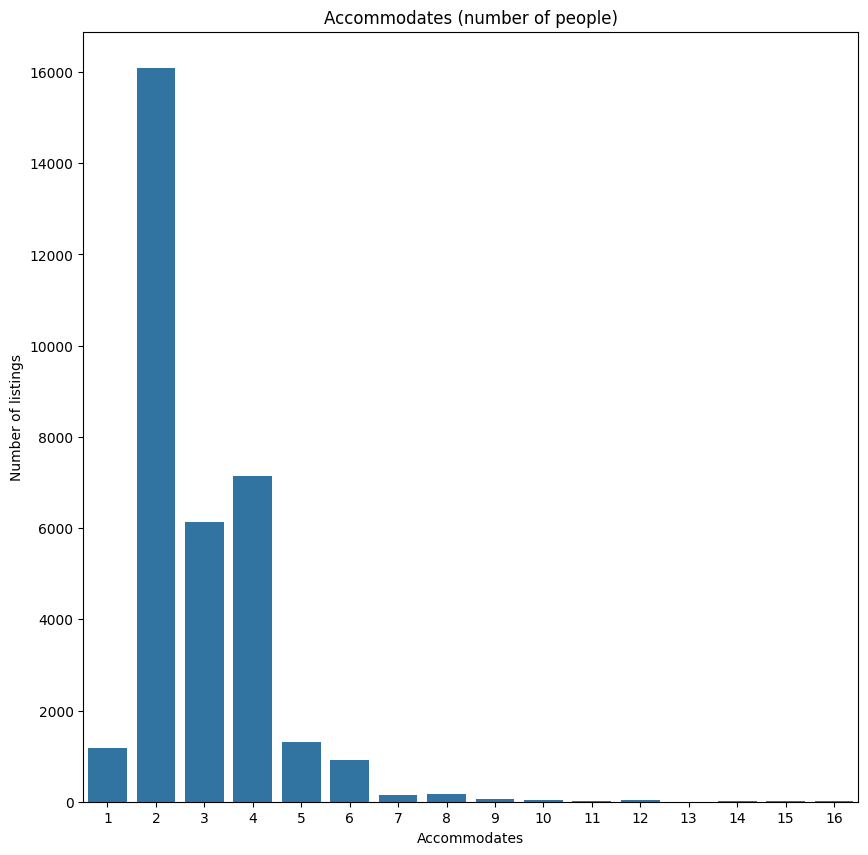

In [224]:
freq = listings_df["accommodates"].value_counts()

# Plot horizontal barplot
plt.figure(figsize=(10, 10))
sns.barplot(x=freq.index, y=freq.values)

# Add label and title
plt.xlabel("Accommodates")
plt.ylabel("Number of listings")
plt.title("Accommodates (number of people)")

plt.show()

## 3.4 Reviews

Guests can submit an overall star rating and a set of category scores. They can give ratings on:

- **Overall Experience (Rating).** What was your overall experience?
- **Cleanliness.** Did you feel that your space was clean and tidy?
- **Accuracy.** How accurately did your listing page represent your space?
- **Value.** Did you feel your listing provided good value for the price?
- **Communication.** How well did you communicate with your host before and during their stay?
- **Arrival.** How smoothly did their check-in go?
- **Location.** How did you feel about the neighborhood?

In [225]:
# Only listings with 10 reviews or more
df = listings_df[listings_df["number_of_reviews"] >= 10]

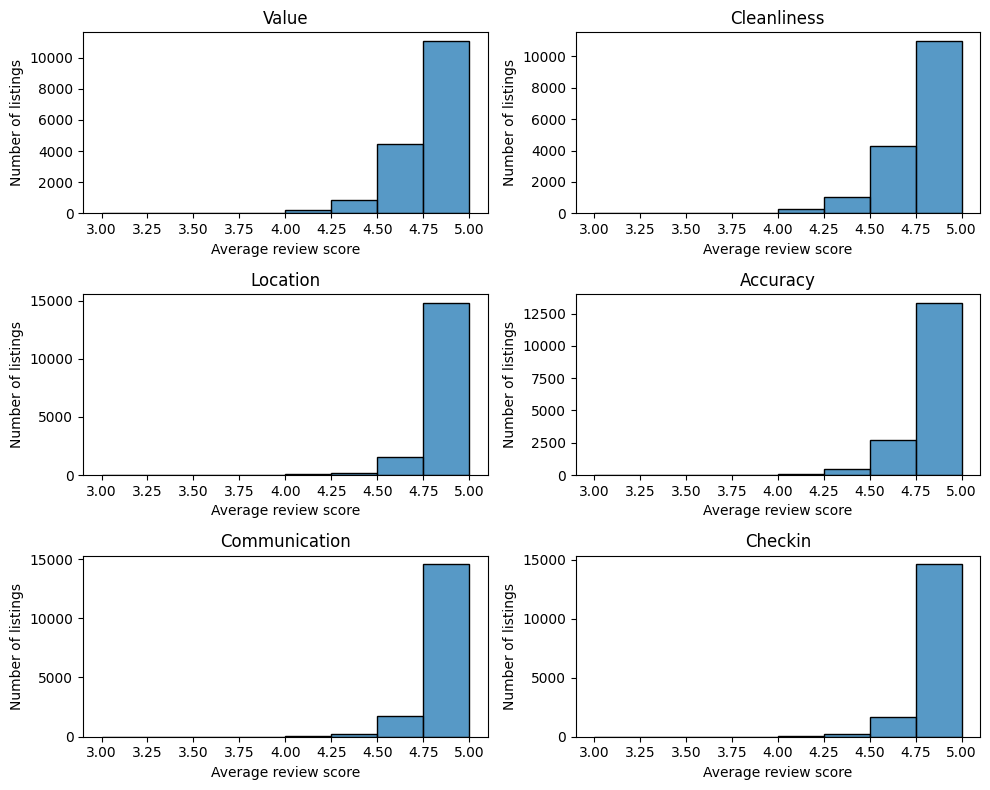

In [226]:
review_scores = [
    "review_scores_value", "review_scores_cleanliness", "review_scores_location",
    "review_scores_accuracy", "review_scores_communication", "review_scores_checkin"
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()

bins = np.arange(3, 5 + 0.25, 0.25)

for i, score in enumerate(review_scores):
    # Plot
    sns.histplot(df[score], ax=axes[i], bins=bins)
    
    # Set labels
    axes[i].set_ylabel("Number of listings")
    axes[i].set_xlabel("Average review score")
    axes[i].set_title(score.split("_")[-1].title())

plt.tight_layout()
plt.show()

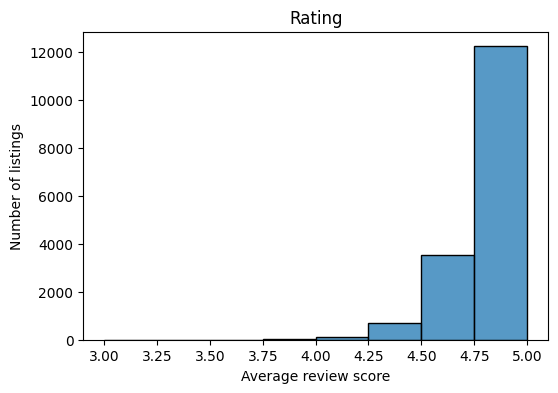

In [227]:
f, ax = plt.subplots(figsize=(6,4))

bins = np.arange(3, 5 + 0.25, 0.25)

sns.histplot(df["review_scores_rating"], ax=ax, bins=bins)
ax.set_ylabel("Number of listings")
ax.set_xlabel("Average review score")
ax.set_title("Rating")

plt.show()

Checking all the categories, we can see easily that scores are really high for every listing. This seems common across Airbnb, as is explained in these articles:
- [At Airbnb, Where Every Stay Is Above Average](https://www.bu.edu/articles/2015/at-airbnb-where-every-stay-is-above-average/)
- [Higher than the average rating? 95% of Airbnb listings rated 4.5 to 5 stars](https://mashable.com/archive/airbnb-reviews-above-average#1YLfzOC34sqd)

After seeing the distributions, I would consider any score lower than 4.5 to be a bad score, and only consider as great scores, those at least greater than 4.86 (It looks like a high score but 50% of the listings are above this rating!)

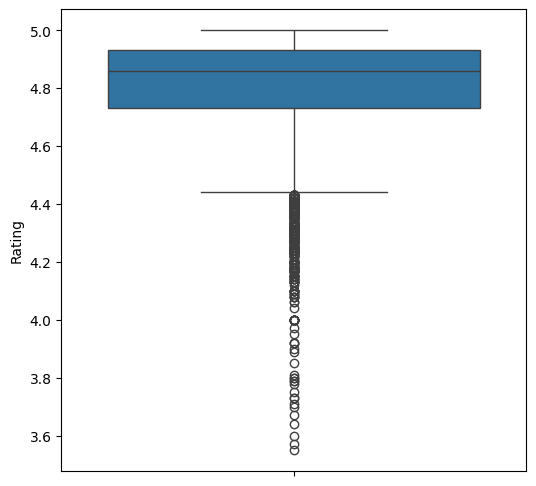

count    16610.000000
mean         4.813623
std          0.166826
min          3.550000
25%          4.730000
50%          4.860000
75%          4.930000
max          5.000000
Name: review_scores_rating, dtype: float64


In [228]:
f, ax = plt.subplots(figsize=(6,6))

sns.boxplot(y=df["review_scores_rating"], ax=ax)

ax.set_ylabel("Rating")

plt.show()
print(df["review_scores_rating"].describe())

# 4. Analysis

## 4.1 Price vs Location analysis

In order to compare similar rental units, let's select the most common type of accommodation: 2 persons.

In [229]:
listings_2persons_df = listings_df[listings_df["accommodates"] == 2]

### 4.1.1 Average daily price per neighbourhood

As expected, Puerto Madero is the most expensive neighbourhood by a wide margin.

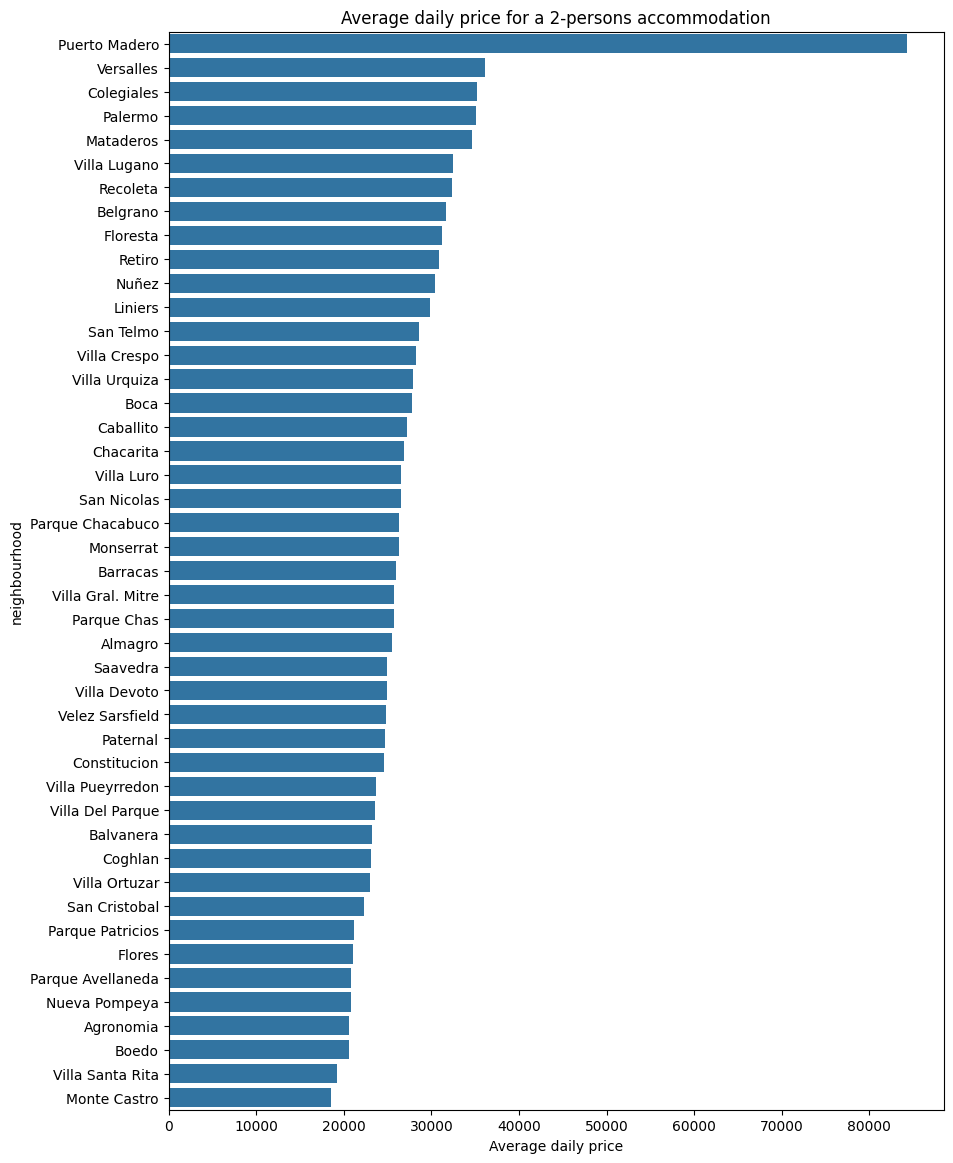

In [230]:
price_per_neighbourhood = listings_2persons_df.groupby('neighbourhood')["price"].mean().sort_values(ascending=False)

# Plot horizontal barplot
plt.figure(figsize=(10, 14))
sns.barplot(x=price_per_neighbourhood.values, y=price_per_neighbourhood.index, orient="h")

# Add label and title
plt.xlabel("Average daily price")
plt.title("Average daily price for a 2-persons accommodation")


plt.show()

Below you can see the data on a map. Hovering over the polygons shows the name of the neighbourhood and their respective average price (in ARS) for 2-persons accommodations.

In [231]:
neighbourhoods_df = gpd.read_file("input/neighbourhoods.geojson")
neighbourhoods_df.drop(columns="neighbourhood_group", inplace=True)

# Merge geodata with average price
neighbourhoods_df = pd.merge(neighbourhoods_df, price_per_neighbourhood, on="neighbourhood", how="left")

# Drop neighbourhoods with no values
neighbourhoods_df.dropna(inplace=True)

# Rename price columns and round values
neighbourhoods_df.rename(columns={"price": "average_price"}, inplace=True)
neighbourhoods_df["average_price"] = neighbourhoods_df["average_price"].round(decimals=0)

neighbourhoods_df.head()

,neighbourhood,geometry,average_price
0,Chacarita,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366...",26883.0
1,Villa Crespo,"MULTIPOLYGON (((-58.42376 -34.59783, -58.42496...",28198.0
2,Palermo,"MULTIPOLYGON (((-58.42676 -34.55202, -58.42676...",35119.0
3,Parque Chas,"MULTIPOLYGON (((-58.47082 -34.58744, -58.47082...",25750.0
4,Villa Del Parque,"MULTIPOLYGON (((-58.49461 -34.61486, -58.49478...",23526.0


In [232]:
map_dict = neighbourhoods_df.set_index('neighbourhood')['average_price'].to_dict()

log_values = np.log(list(map_dict.values()))
color_scale = LinearColormap(['green', 'yellow', 'red'], vmin=min(log_values), vmax=max(log_values))


def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(np.log(value))

bsas_map = folium.Map(location=[-34.6, -58.45], zoom_start=12)
folium.GeoJson(data=neighbourhoods_df,
               name='Buenos Aires',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(bsas_map)
bsas_map

### 4.1.2 Daily Price vs Location Score

With last section's results, we can start to hypothesize which factors related to location influence the price. Some of them could be:

- **Tourist locations.** Having parks, museums, bars or other tourist attractions nearby could make the location more expensive.
- **Safety.** We can see that northern neighbourhoods such as Recoleta, Palermo, Colegiales, Belgrano are expensive. This part of the city is usually considered safer that the southern neighbourhoods.
- **Public transport.** If a place is located far from the city most tourist locations but has easy public transportation access, it's average price could be higher.

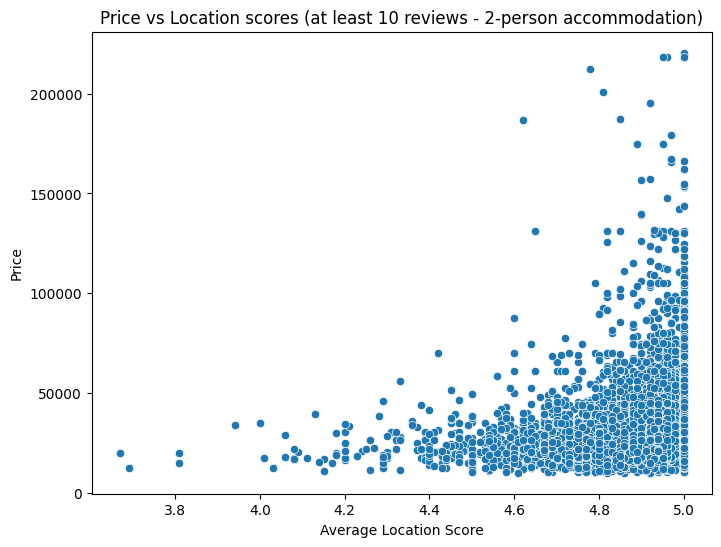

In [233]:
# Only listings with 10 reviews or more and accommodation for 2
df = listings_2persons_df[listings_2persons_df["number_of_reviews"] >= 10]

f, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x="review_scores_location", y="price", data=df)
ax.set_title("Price vs Location scores (at least 10 reviews - 2-person accommodation)")
ax.set_xlabel("Average Location Score")
ax.set_ylabel("Price")

plt.show()

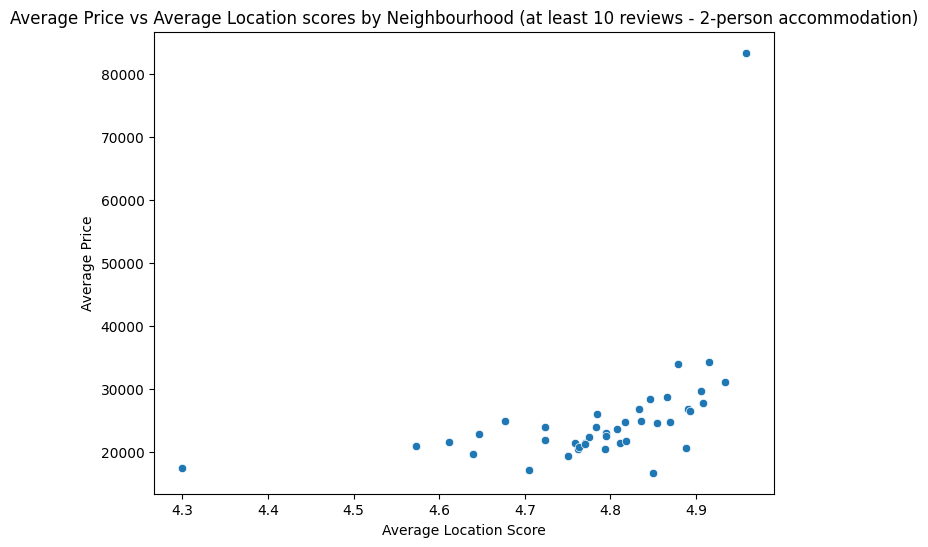

In [234]:
price_vs_location_by_neighbourhood = df.groupby('neighbourhood')[["price", "review_scores_location"]].mean()

f, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x="review_scores_location", y="price", data=price_vs_location_by_neighbourhood)
ax.set_title("Average Price vs Average Location scores by Neighbourhood (at least 10 reviews - 2-person accommodation)")
ax.set_xlabel("Average Location Score")
ax.set_ylabel("Average Price")

plt.show()

We can see that there looks to be a positive correlation between Price and Location Score. If we look at the correlation matrix below, we can see that the Location Score is the Review Score with the higher correlation with Price.

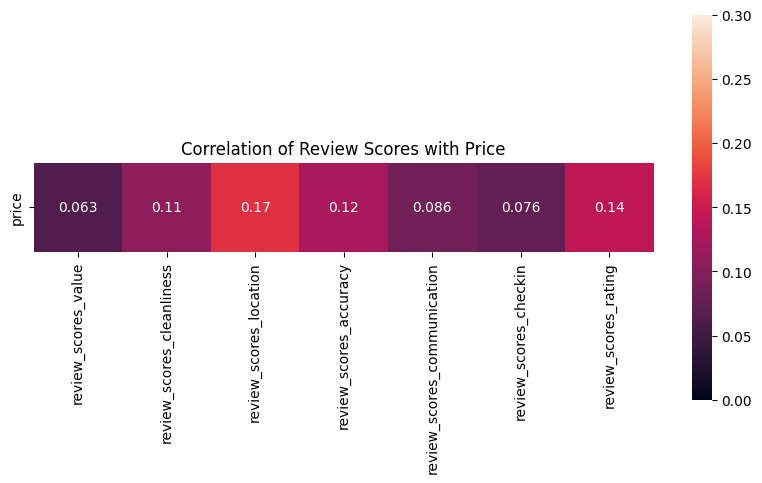

In [235]:
columns_of_interest = ["review_scores_value", "review_scores_cleanliness", "review_scores_location",
                       "review_scores_accuracy", "review_scores_communication", "review_scores_checkin",
                       "review_scores_rating", "price"]

# Selecting the subset of columns from your DataFrame
df_subset = df[columns_of_interest]

# Calculate correlations of PRICE with each variable
corr_with_price = df_subset.corr()['price'].drop('price')

# Create a DataFrame for the heatmap
heatmap_data = pd.DataFrame(corr_with_price)

# Plotting the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data.transpose(), annot=True, vmin=0, vmax=0.3, square=True)
plt.title('Correlation of Review Scores with Price')
plt.show()

## 4.2 Availability

### 4.2.1 Availability over time

The calendar file holds 365 records for each listing, which means that for each listing the price and availablity by date is specified 365 days ahead.

In [236]:
calendar_df.shape

(13344511, 5)

Important to note: 
- Availability 0 means that either the owner does not want to rent out his property on the specific date, or the listing has been booked for that date already.
- Price here is shown in US Dollars, because of the high inflation rates of the ARS peso (Interannual inflation in April 2024 was 289.4%).

A sample of the calendar data is shown below. We will merge the 'accomodates' variable with the calendar, to later compare only 2-persons accommodations when we are checking for prices by time.

In [237]:
listings = listings_df.copy()
listings.index.name = "listing_id"
calendar = pd.merge(calendar_df, listings[["accommodates"]], on="listing_id", how="inner")
calendar.sample(10)

,date,available,price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,
2078803,2025-03-30,True,12500.0,1.0,1125.0,1
30558832,2024-05-18,True,37.0,2.0,1125.0,2
39610786,2024-11-21,False,28.0,4.0,1125.0,2
34201838,2024-10-17,True,55.0,3.0,1125.0,2
20439841,2025-03-18,True,30.0,3.0,90.0,2
771016939390592717,2024-07-31,True,40.0,3.0,365.0,2
1071326431300737414,2025-01-10,True,20.0,5.0,365.0,2
584992856445516290,2024-11-04,True,25.0,3.0,365.0,3
21031306,2024-05-16,True,28.0,2.0,1125.0,2


Below, we see steps every three months. Hosts probably update their listings in this timeframe, with more focus in the closer dates.

In [238]:
sum_available = calendar[calendar["available"] == True].groupby(["date"]).size().to_frame(name="available").reset_index()

sum_available["date"] = np.array(pd.to_datetime(sum_available["date"]))
sum_available["weekday"] = sum_available["date"].dt.day_name()
sum_available.set_index("date")

fig = px.line(sum_available, title="Number of listings available by date", x="date", y="available", hover_name="weekday")
fig.update_layout(hovermode="x")

fig.show()

d:\Python\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### 4.2.2 Average price by date

Now we will deal with the outliers we found in [2.2 Calendar](#22-calendar).

In [239]:
calendar_price = calendar_df.copy()

calendar_price_prev = calendar_price.copy()

upper_bound = calendar_price['price'].quantile(0.95)
lower_bound = calendar_price['price'].quantile(0.05)

print(upper_bound, lower_bound)

379.0 18.0


In [240]:
calendar_price = calendar_price[(calendar_price['price'] >= lower_bound) & (calendar_price['price'] <= upper_bound)]
print ("Shape before removing outliers: ", calendar_price_prev.shape)
print ("Shape after removing outliers: ", calendar_price.shape)

Shape before removing outliers:  (13344511, 5)
Shape after removing outliers:  (12021747, 5)


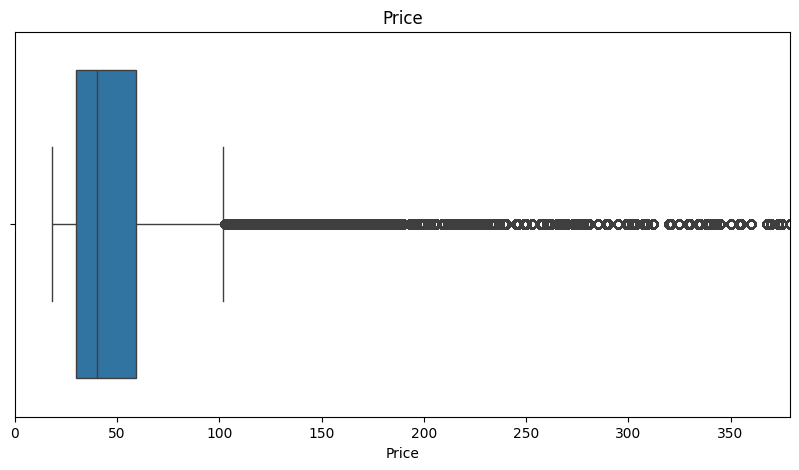

count    1.202175e+07
mean     5.196829e+01
std      3.950409e+01
min      1.800000e+01
25%      3.000000e+01
50%      4.000000e+01
75%      5.900000e+01
max      3.790000e+02
Name: price, dtype: float64


In [241]:
# Plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=calendar_price["price"])

# Add title and label
plt.title("Price")
plt.xlabel("Price")

plt.xlim(0, calendar_price["price"].max())

plt.show()
print(calendar_price["price"].describe())

Now we will merge this dataframe with accommodates from listings.

In [242]:
calendar_price = pd.merge(calendar_price, listings[["accommodates"]], on="listing_id", how="inner")
calendar_price.sample(10)

,date,available,price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,
1071156655778624370,2024-10-13,True,22.0,2.0,365.0,2
726911336596042544,2024-07-09,False,50.0,2.0,1125.0,2
973377635975337375,2025-01-05,True,45.0,7.0,365.0,4
1094395050613652811,2024-09-29,True,24.0,3.0,365.0,2
1110775051307899429,2024-07-26,True,65.0,1.0,365.0,4
973153784810679386,2025-04-01,False,49.0,1.0,1125.0,6
1005231558648333295,2024-05-05,True,28.0,7.0,90.0,3
935503712731645033,2025-04-12,False,29.0,2.0,1125.0,2
822343418152848268,2025-02-04,False,22.0,3.0,60.0,2


We can see that the average price isn't affected by date in Buenos Aires.

In [243]:
average_price = calendar_price[(calendar_price["available"] == True) & (calendar_price["accommodates"] == 2)].groupby(['date']).mean().astype(np.int64).reset_index()

average_price["date"] = np.array(pd.to_datetime(average_price["date"]))
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

fig = px.line(average_price, title="Average price of available 2-persons accommodations by date", x=average_price.index, y="price", hover_name="weekday")
fig.update_layout(hovermode="x")

fig.show()

d:\Python\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## 4.3 Quality of hosts

"Superhost" is a status that Airbnb gives to hosts. Every 3 months, Airbnb checks if a host meets the following criteria. If they do, they'll earn or keep their Superhost status.
- Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year.
- Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays.
- Superhosts have no cancellations in the past year, unless there were extenuating circumstances.
- Superhosts respond to 90% of new messages within 24 hours.

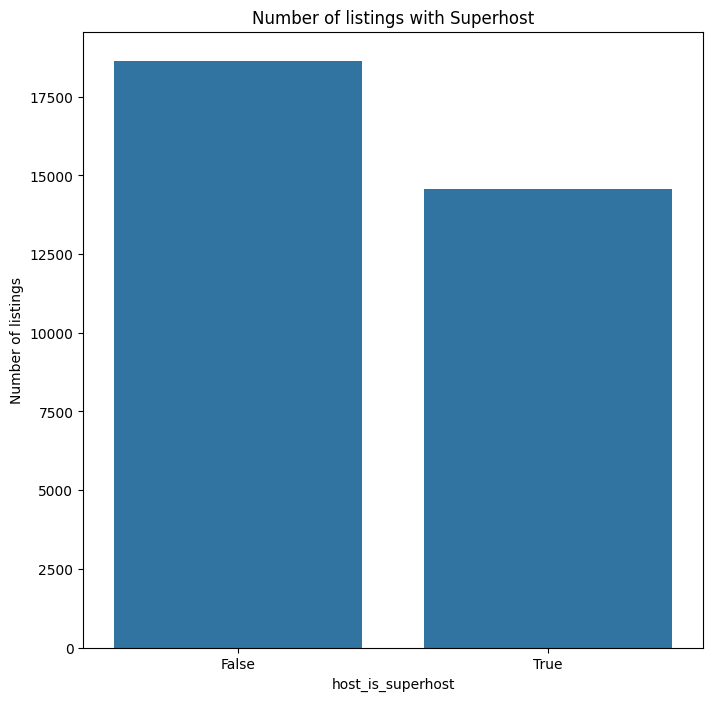

In [244]:
freq = listings_df.host_is_superhost.value_counts()

plt.figure(figsize=(8, 8))
sns.barplot(x=freq.index, y=freq.values)

plt.ylabel("Number of listings")
plt.title("Number of listings with Superhost")

plt.show()

43.85% of listings in Buenos Aires have Superhosts. Is this an important segmentation? Should you pick a Superhost over a normal host?

Average rating shouldn't be a concern. Superhosts need an average rating of 4.8, and, as we shown in [3.4 Reviews](#34-reviews), 50% of the listings have an average rating higher than 4.86.

Let's see if Superhost charge more than regular host because of their status.

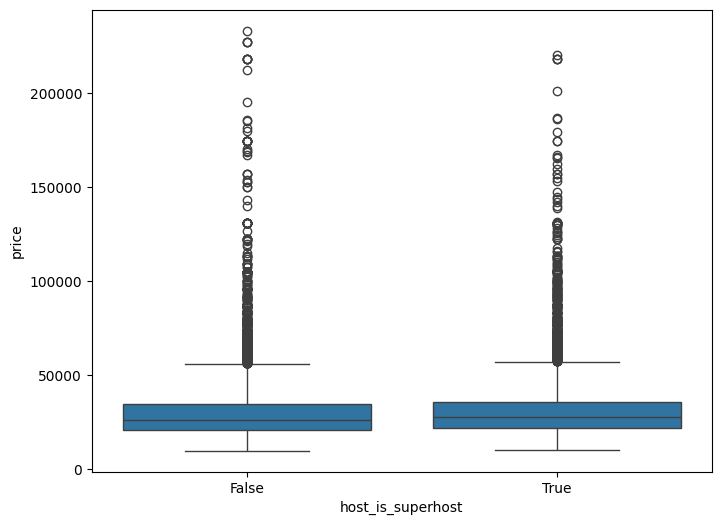

In [245]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="host_is_superhost", y="price", data=listings_2persons_df)

plt.show()

In [246]:
superhost_price = listings_2persons_df[listings_2persons_df['host_is_superhost'] == True]['price']
superhost_price.describe()

count      6975.000000
mean      32372.761434
std       17791.620310
min       10115.000000
25%       21856.000000
50%       27975.000000
75%       36066.500000
max      220527.000000
Name: price, dtype: float64

In [247]:
regular_host_price = listings_2persons_df[listings_2persons_df['host_is_superhost'] == False]['price']
regular_host_price.describe()

count      9079.000000
mean      30732.752396
std       18486.966883
min       10000.000000
25%       20728.000000
50%       26227.000000
75%       34969.000000
max      233419.000000
Name: price, dtype: float64

In [248]:
print("Superhost average price for 2-person accommodation", superhost_price.mean())
print("Regular host average price for 2-person accommodation", regular_host_price.mean())

Superhost average price for 2-person accommodation 32372.761433691758
Regular host average price for 2-person accommodation 30732.752395638287


We can see both distributions seem similar. Regular hosts charge, on average, ARS$1500 (around USD$1.5) less than Superhosts per day.

Below we can see that almost every host responds quickly, so the criteria that separates Superhosts from regular hosts are number of previous hosted stays, which, in my opinion, isn't really important for guests, and having no cancellations the past year.

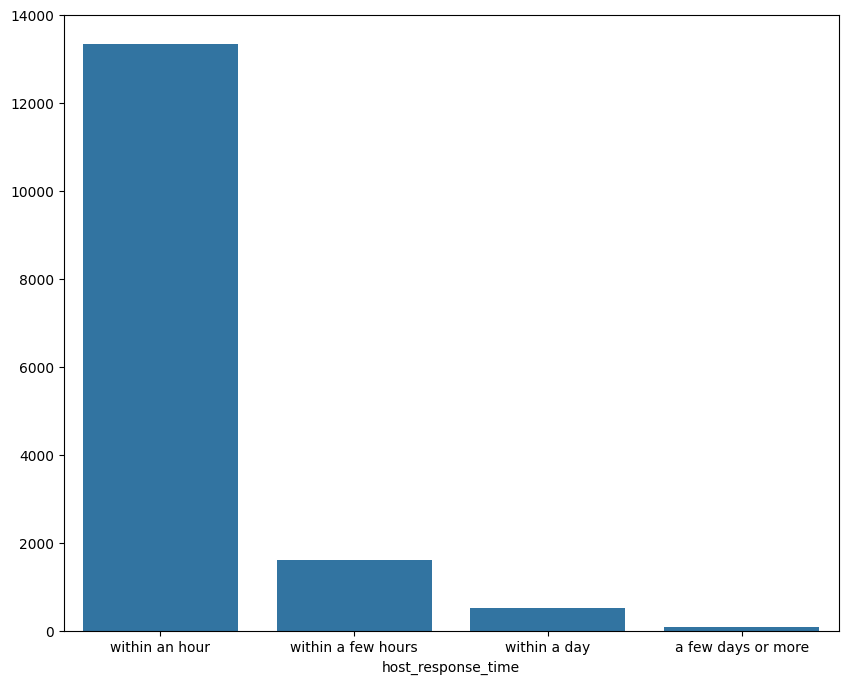

In [249]:
# Only listings with 10 reviews or more
listing10 = listings_df[listings_df["number_of_reviews"] >= 10]

freq = listing10["host_response_time"].value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(x=freq.index, y=freq.values)

plt.show()